In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2

2022-12-16 17:28:14.958257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 17:28:15.051327: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-16 17:28:15.071941: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 17:28:15.440074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
from sklearn.preprocessing import OneHotEncoder
from augmenter import augment
import itertools


import keras
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier

from sklearn import metrics
import matplotlib.pyplot as plt

## remove outliers

In [3]:
label_file_path = os.path.join("..", "FF-Hackaton-Data", "rooftype_labels.csv")
image_dir_path = os.path.join("..", "FF-Hackaton-Data", "Nadir afbeeldingen", "Nadir afbeeldingen")

In [4]:
label_file = pd.read_csv(label_file_path, converters={'id': str})

In [5]:
label_file = label_file.drop("labled_by", axis=1)

In [6]:
label_file = label_file[label_file.label != "mansardedak"]
label_file = label_file[label_file.label != "lessenaarsdak"]
label_file = label_file[label_file.label != "schilddak"]

In [7]:
ids_to_be_removed = []
for filename in os.listdir(image_dir_path):
    f = os.path.join(image_dir_path, filename)
    if os.path.isfile(f):
        img = cv2.imread(f)
        if np.mean(img) >= 255:
            ids_to_be_removed.append(os.path.splitext(filename)[0])
        

In [8]:
label_file = label_file[~label_file["id"].isin(ids_to_be_removed)]

In [9]:
label_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4872 entries, 0 to 4891
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4872 non-null   object
 1   label   4872 non-null   object
dtypes: object(2)
memory usage: 114.2+ KB


In [10]:
label_file["label"].value_counts()

langskap      4119
platdak        501
combinatie     179
dwarskap        73
Name: label, dtype: int64

In [11]:
label_file.head()

,id,label
0,0303100000583305,langskap
1,0303100000581886,langskap
2,0303100000584592,langskap
3,0303100000584818,langskap
4,0303100000584826,langskap


## stratified split

In [12]:
filename_X = label_file["id"].to_numpy()
y = label_file["label"].to_numpy()

In [13]:
if (len(filename_X) != len(y)):
    raise Exception("oops")

In [14]:
from sklearn.model_selection import train_test_split
filename_train_X, filename_test_X, train_y, test_y = train_test_split(filename_X, y,
                                                    stratify=y, 
                                                    test_size=0.2)

## load images from disk

In [15]:
def load_images(filenames, img_size):
    images = []
    for filename in filenames:
        file_path = os.path.join(image_dir_path, filename + ".jpg")
        img = cv2.imread(file_path)
        img = cv2.resize(img, img_size)
        images.append(img)
        
    return images

In [16]:
train_X = load_images(filename_train_X, (192, 192))
test_X = load_images(filename_test_X, (192, 192))

## TODO augments

In [17]:
augment(train_X, train_y)

augmenting label: {} combinatie
augmenting label: {} dwarskap
augmenting label: {} platdak


In [18]:
train_y = OneHotEncoder().fit_transform(np.array(train_y).reshape(-1,1)).reshape(-1, 4).toarray()
test_y = OneHotEncoder().fit_transform(np.array(test_y).reshape(-1,1)).reshape(-1, 4).toarray()

## create model

In [19]:
def create_model(dropout_rate=0.0):
    model = Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape = (192, 192, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu', use_bias=True, bias_initializer='ones'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation = 'softmax', use_bias=True, bias_initializer='ones'),
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, dropout_rate=0.2)

In [20]:
model.fit(train_X, train_y, epochs=25)

2022-12-16 17:33:36.000043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-16 17:33:36.084509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-16 17:33:36.084552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-16 17:33:36.085290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

Epoch 1/25


2022-12-16 17:33:38.289043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2022-12-16 17:33:39.022809: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


122/122 [==============================] - 4s 18ms/step - loss: 0.5729 - accuracy: 0.8304
Epoch 2/25
122/122 [==============================] - 2s 17ms/step - loss: 0.2499 - accuracy: 0.8489
Epoch 3/25
122/122 [==============================] - 2s 17ms/step - loss: 0.2317 - accuracy: 0.8609
Epoch 4/25
122/122 [==============================] - 2s 17ms/step - loss: 0.2087 - accuracy: 0.8686
Epoch 5/25
122/122 [==============================] - 2s 17ms/step - loss: 0.1993 - accuracy: 0.8704
Epoch 6/25
122/122 [==============================] - 2s 17ms/step - loss: 0.1759 - accuracy: 0.8835
Epoch 7/25
122/122 [==============================] - 2s 17ms/step - loss: 0.1679 - accuracy: 0.8894
Epoch 8/25
122/122 [==============================] - 2s 17ms/step - loss: 0.1538 - accuracy: 0.9015
Epoch 9/25
122/122 [==============================] - 2s 17ms/step - loss: 0.1307 - accuracy: 0.9110
Epoch 10/25
122/122 [==============================] - 2s 17ms/step - loss: 0.1206 - accuracy: 0.9194


KerasClassifier(
	model=<function create_model at 0x7fac03f10d30>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	dropout_rate=0.2
	class_weight=None
)

In [21]:
test_pred_y = model.predict(test_X).astype(np.float64)

31/31 [==============================] - 0s 7ms/step


In [31]:
confusion_matrix = metrics.confusion_matrix(test_y.argmax(axis=1), test_pred_y.argmax(axis=1))
# confusion_matrix = confusion_matrix / confusion_matrix.astype(np.float64).sum(axis=1)

In [32]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

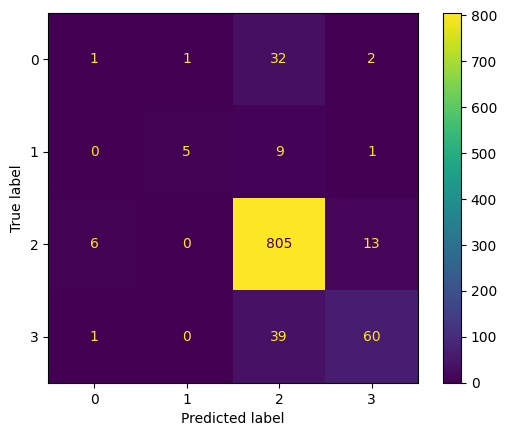

In [33]:
cm_display.plot()
plt.show()

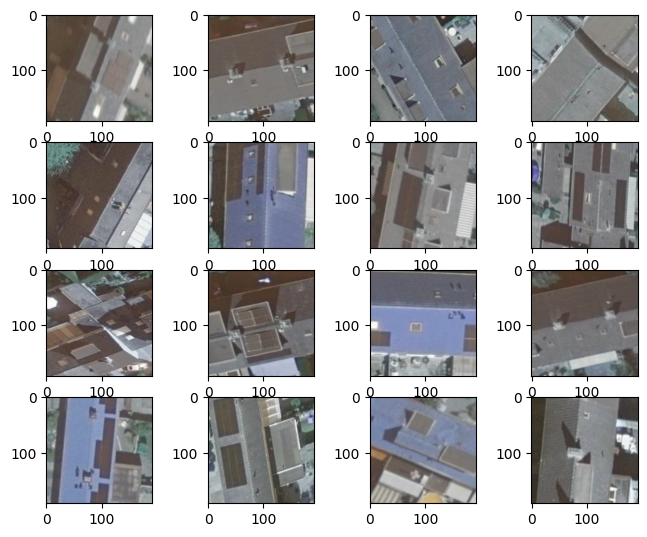

In [30]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 17):
    fig.add_subplot(5, 4, i)
    plt.imshow(train_X[len(train_X) - i])